# Set Up Environment
Import the libraries used across the analysis and define the directory layout for model artifacts.

In [52]:
%matplotlib inline

import json
from pathlib import Path
from typing import Dict, List

import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display
from matplotlib import pyplot as plt

sns.set_theme(style="whitegrid")

PROJECT_ROOT = Path.cwd().resolve()
MODELS_DIR = PROJECT_ROOT.parent / "models"
REPORTS_DIR = PROJECT_ROOT / "reports"
REPORTS_DIR.mkdir(parents=True, exist_ok=True)

print(f"Project root: {PROJECT_ROOT}")
print(f"Models directory: {MODELS_DIR}")
print(f"Reports directory: {REPORTS_DIR}")

Project root: C:\Users\ineza\Documents\Anna\ALU\machine_learning\ml_techniques\summatives\reinforcement-learning-ml-techniques-2-summative\training
Models directory: C:\Users\ineza\Documents\Anna\ALU\machine_learning\ml_techniques\summatives\reinforcement-learning-ml-techniques-2-summative\models
Reports directory: C:\Users\ineza\Documents\Anna\ALU\machine_learning\ml_techniques\summatives\reinforcement-learning-ml-techniques-2-summative\training\reports


# Load Experiment Metadata
Load the metadata JSON files emitted by each training script and assemble a consolidated table.

In [53]:
def load_run_metadata(models_dir: Path) -> pd.DataFrame:
    if not models_dir.exists():
        print(f"Models directory not found: {models_dir}")
        return pd.DataFrame()

    records: List[Dict[str, object]] = []

    for algo_dir in sorted([p for p in models_dir.iterdir() if p.is_dir()]):
        algo_name = algo_dir.name

        summary_path = algo_dir / f"{algo_name}_results.json"
        if summary_path.exists():
            content = json.loads(summary_path.read_text(encoding="utf-8"))
            for item in content:
                snapshot = dict(item)
                snapshot.setdefault("algo", algo_name)
                snapshot.setdefault("metadata_source", "summary")
                snapshot.setdefault("run_name", f"{algo_name}_summary")
                snapshot.setdefault("hyperparameters", snapshot.get("hyperparameters", {}))
                records.append(snapshot)

        for run_metadata in algo_dir.glob("run_*/metadata.json"):
            data = json.loads(run_metadata.read_text(encoding="utf-8"))
            snapshot = dict(data)
            snapshot.setdefault("algo", algo_name)
            snapshot.setdefault("metadata_source", "run")
            snapshot.setdefault("run_name", run_metadata.parent.name)
            snapshot.setdefault("hyperparameters", snapshot.get("hyperparameters", {}))
            records.append(snapshot)

    if not records:
        print("No metadata files discovered. Run training scripts before analysis.")
        return pd.DataFrame()

    frame = pd.DataFrame(records)
    if "algo" in frame.columns:
        frame["algo"] = frame["algo"].str.upper()
    return frame


metadata_df = load_run_metadata(MODELS_DIR)
print(f"Loaded {len(metadata_df)} metadata rows")
display(metadata_df.head())

Loaded 80 metadata rows


,algo,run_index,seed,hyperparameters,training_walltime_sec,eval_mean_reward,eval_std_reward,callback_best_mean_reward,best_model_path,final_model_path,tensorboard_log_dir,metadata_source,run_name,best_smoothed_reward,episode_rewards_path,policy_path
0,A2C,0,42,"{'learning_rate': 0.0007, 'gamma': 0.99, 'n_st...",1004.111077,34.100000,48.284556,27.875000,models\a2c\run_00\best_model\best_model.zip,models\a2c\run_00\final_model.zip,training_logs\a2c,summary,a2c_summary,NaN,NaN,NaN
1,A2C,1,43,"{'learning_rate': 0.0005, 'gamma': 0.98, 'n_st...",756.050852,110.162500,50.610716,86.766667,models\a2c\run_01\best_model\best_model.zip,models\a2c\run_01\final_model.zip,training_logs\a2c,summary,a2c_summary,NaN,NaN,NaN
2,A2C,2,44,"{'learning_rate': 0.0003, 'gamma': 0.995, 'n_s...",845.361547,-17.562500,38.577679,5.204167,models\a2c\run_02\best_model\best_model.zip,models\a2c\run_02\final_model.zip,training_logs\a2c,summary,a2c_summary,NaN,NaN,NaN
3,A2C,3,45,"{'learning_rate': 0.0009, 'gamma': 0.97, 'n_st...",715.182179,102.075000,46.941210,100.183333,models\a2c\run_03\best_model\best_model.zip,models\a2c\run_03\final_model.zip,training_logs\a2c,summary,a2c_summary,NaN,NaN,NaN
4,A2C,4,46,"{'learning_rate': 0.0004, 'gamma': 0.98, 'n_st...",884.029112,-149.120833,2.202078,-151.275000,models\a2c\run_04\best_model\best_model.zip,models\a2c\run_04\final_model.zip,training_logs\a2c,summary,a2c_summary,NaN,NaN,NaN


# Parse Training Metrics
Extract time-series evaluation results stored alongside each run into tidy tables suitable for analysis.

In [54]:
def build_performance_summary(metadata: pd.DataFrame, evals: pd.DataFrame) -> pd.DataFrame:
    if metadata.empty:
        return pd.DataFrame()

    run_rows = metadata[metadata.get("metadata_source", "run") == "run"].copy()
    run_rows = run_rows.replace({np.nan: None})

    summary_cols = [
        "algo",
        "run_name",
        "metadata_source",
        "training_walltime_sec",
        "eval_mean_reward",
        "eval_std_reward",
        "callback_best_mean_reward",
        "best_smoothed_reward",
        "best_reward",
        "best_reward_step",
        "hyperparameters",
        "best_model_path",
        "final_model_path",
        "policy_path",
        "episode_rewards_path",
    ]

    available_cols = [col for col in summary_cols if col in run_rows.columns]
    summary = run_rows[available_cols].copy()

    if not evals.empty:
        final_eval = (
            evals.sort_values(["algo", "run_name", "timesteps"])
            .groupby(["algo", "run_name"], as_index=False)
            .tail(1)
            .rename(columns={"mean_reward": "eval_callback_mean", "std_reward": "eval_callback_std"})
        )
        summary = summary.merge(final_eval, on=["algo", "run_name"], how="left")

    if "eval_mean_reward" not in summary.columns or summary["eval_mean_reward"].isna().all():
        summary["eval_mean_reward"] = summary.get("eval_callback_mean")

    if "eval_std_reward" not in summary.columns or summary["eval_std_reward"].isna().all():
        summary["eval_std_reward"] = summary.get("eval_callback_std")

    summary["score_for_rank"] = summary["eval_mean_reward"].fillna(-np.inf)
    summary["reward_rank"] = summary.groupby("algo")["score_for_rank"].rank(ascending=False, method="dense")

    return summary.sort_values(["algo", "reward_rank", "run_name"]).reset_index(drop=True)


summary_df = build_performance_summary(metadata_df, eval_df)
print(f"Performance summary rows: {len(summary_df)}")
display(summary_df.head())

Performance summary rows: 40


C:\Users\ineza\AppData\Local\Temp\ipykernel_19676\3060038402.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  summary["score_for_rank"] = summary["eval_mean_reward"].fillna(-np.inf)


,algo,run_name,metadata_source,training_walltime_sec,eval_mean_reward,eval_std_reward,callback_best_mean_reward,best_smoothed_reward,hyperparameters,best_model_path,...,policy_path,episode_rewards_path,timesteps,eval_callback_mean,eval_callback_std,median_reward,mean_ep_length,source_file,score_for_rank,reward_rank
0,A2C,run_01,run,756.050852,110.1625,50.610716,86.766667,None,"{'learning_rate': 0.0005, 'gamma': 0.98, 'n_st...",models\a2c\run_01\best_model\best_model.zip,...,None,None,180000.0,86.766667,48.644810,92.066666,50.0,models\a2c\run_01\eval_logs\evaluations.npz,110.162500,1.0
1,A2C,run_03,run,715.182179,102.075,46.94121,100.183333,None,"{'learning_rate': 0.0009, 'gamma': 0.97, 'n_st...",models\a2c\run_03\best_model\best_model.zip,...,None,None,180000.0,52.479167,38.950570,45.216667,50.0,models\a2c\run_03\eval_logs\evaluations.npz,102.075000,2.0
2,A2C,run_09,run,1101.949451,88.695833,60.727329,122.6625,None,"{'learning_rate': 0.00035, 'gamma': 0.99, 'n_s...",models\a2c\run_09\best_model\best_model.zip,...,None,None,180000.0,-28.895833,27.251409,-34.883333,50.0,models\a2c\run_09\eval_logs\evaluations.npz,88.695833,3.0
3,A2C,run_07,run,968.637755,67.833333,53.495485,82.695833,None,"{'learning_rate': 0.0008, 'gamma': 0.97, 'n_st...",models\a2c\run_07\best_model\best_model.zip,...,None,None,180000.0,82.695833,42.336714,82.450000,50.0,models\a2c\run_07\eval_logs\evaluations.npz,67.833333,4.0
4,A2C,run_05,run,754.926587,57.666666,51.871513,112.6,None,"{'learning_rate': 0.0006, 'gamma': 0.99, 'n_st...",models\a2c\run_05\best_model\best_model.zip,...,None,None,180000.0,112.600000,41.975132,115.866667,50.0,models\a2c\run_05\eval_logs\evaluations.npz,57.666666,5.0


# Aggregate Model Performance
Combine metadata and evaluation traces to produce summary statistics that make algorithms easy to compare.

In [55]:
def build_performance_summary(metadata: pd.DataFrame, evals: pd.DataFrame) -> pd.DataFrame:
    if metadata.empty:
        return pd.DataFrame()

    run_rows = metadata[metadata.get("metadata_source", "run") == "run"].copy()
    run_rows = run_rows.replace({np.nan: None})

    summary_cols = [
        "algo",
        "run_name",
        "metadata_source",
        "training_walltime_sec",
        "eval_mean_reward",
        "eval_std_reward",
        "best_smoothed_reward",
        "hyperparameters",
        "best_model_path",
        "final_model_path",
    ]

    available_cols = [col for col in summary_cols if col in run_rows.columns]
    summary = run_rows[available_cols].copy()

    if not evals.empty:
        final_eval = (
            evals.sort_values(["algo", "run_name", "timesteps"])
            .groupby(["algo", "run_name"], as_index=False)
            .tail(1)
            .rename(columns={"mean_reward": "eval_callback_mean", "std_reward": "eval_callback_std"})
        )
        summary = summary.merge(final_eval, on=["algo", "run_name"], how="left")

    if "eval_mean_reward" not in summary.columns or summary["eval_mean_reward"].isna().all():
        summary["eval_mean_reward"] = summary.get("eval_callback_mean")

    summary["score_for_rank"] = summary["eval_mean_reward"].fillna(-np.inf)
    summary["reward_rank"] = summary.groupby("algo")["score_for_rank"].rank(ascending=False, method="dense")

    return summary.sort_values(["algo", "reward_rank", "run_name"]).reset_index(drop=True)

# Hyperparameter Tables
Unpack the saved hyperparameters for every run so we can audit the search space and compare settings side-by-side.

# Visualize Training Curves
Plot evaluation rewards over time to observe convergence patterns for every algorithm.

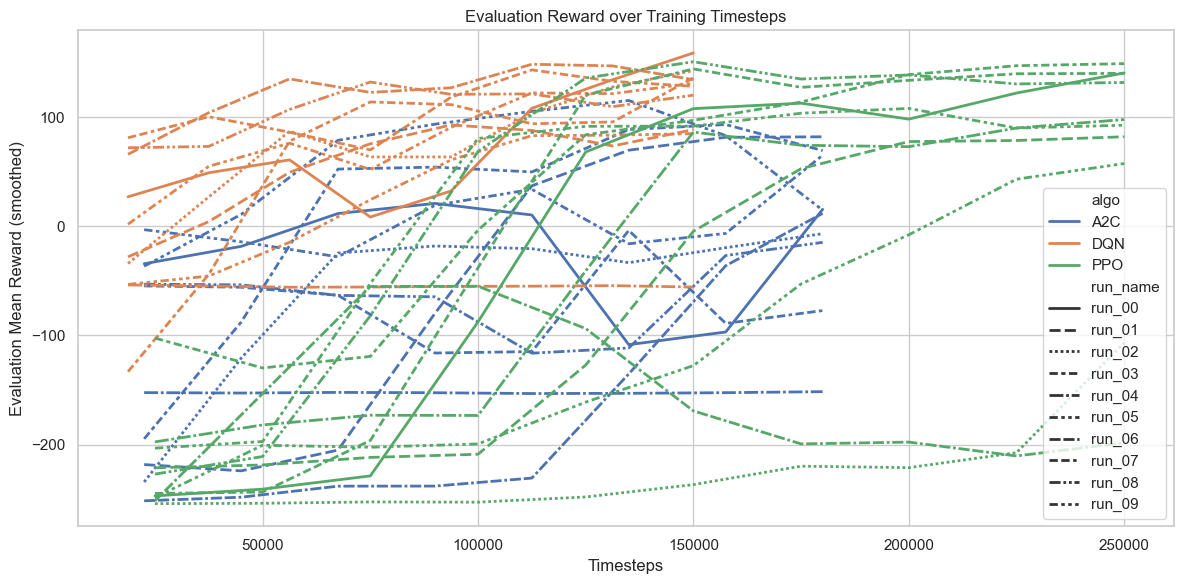

In [56]:
def plot_eval_curves(evals: pd.DataFrame, smoothing: int = 1) -> None:
    if evals.empty:
        print("No evaluation data available for plotting.")
        return

    data = evals.copy()
    if smoothing > 1:
        data["smoothed_reward"] = (
            data.sort_values("timesteps")
            .groupby(["algo", "run_name"])["mean_reward"]
            .transform(lambda s: s.rolling(window=smoothing, min_periods=1).mean())
        )
    else:
        data["smoothed_reward"] = data["mean_reward"]

    plt.figure(figsize=(12, 6))
    sns.lineplot(
        data=data,
        x="timesteps",
        y="smoothed_reward",
        hue="algo",
        style="run_name",
        estimator=None,
        linewidth=2,
    )
    plt.title("Evaluation Reward over Training Timesteps")
    plt.xlabel("Timesteps")
    plt.ylabel("Evaluation Mean Reward (smoothed)")
    plt.tight_layout()
    plt.show()


plot_eval_curves(eval_df, smoothing=2)

# Compare Best Models
Rank models by evaluation reward and visualize cross-algorithm differences.

Top models per algorithm:


,algo,run_name,eval_mean_reward,eval_std_reward,eval_callback_mean,eval_callback_std,training_walltime_sec
0,A2C,run_01,110.1625,50.610716,86.766667,48.644810,756.050852
1,A2C,run_03,102.075,46.94121,52.479167,38.950570,715.182179
2,A2C,run_09,88.695833,60.727329,-28.895833,27.251409,1101.949451
3,DQN,run_08,189.7375,44.915632,146.441667,59.248190,1097.382744
4,DQN,run_00,188.729167,40.430174,166.754167,81.041135,396.258328
5,DQN,run_05,157.8625,50.96567,141.966667,44.316253,1510.70484
6,PPO,run_08,171.395833,33.52923,145.979167,58.301103,583.265616
7,PPO,run_03,145.541667,58.569502,154.545833,56.374090,705.552737
8,PPO,run_07,134.454167,60.033696,135.483333,53.061626,627.758404
9,REINFORCE,run_04,-54.091667,2.400448,NaN,NaN,210.587915


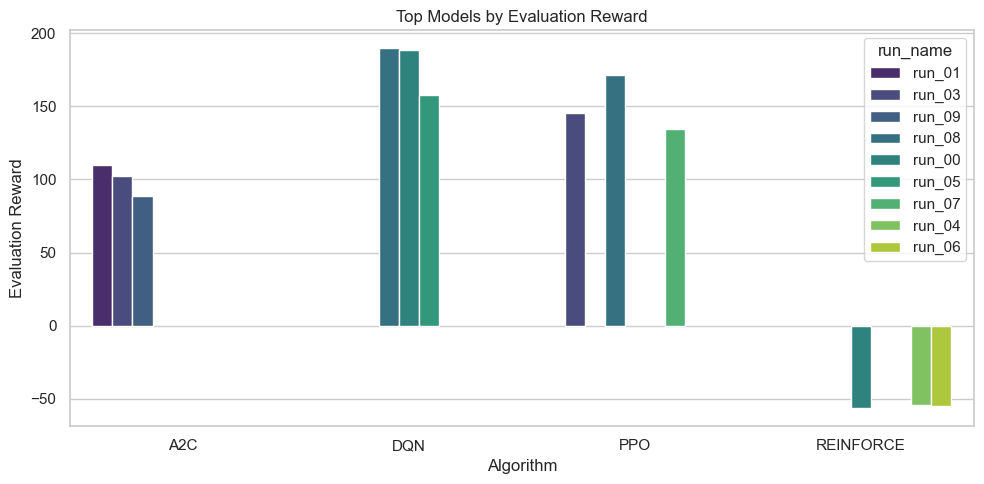

In [57]:
def extract_top_models(summary: pd.DataFrame, top_n: int = 3) -> pd.DataFrame:
    if summary.empty:
        return pd.DataFrame()

    ranked = (
        summary.dropna(subset=["score_for_rank"])
        .sort_values(["algo", "score_for_rank"], ascending=[True, False])
        .groupby("algo")
        .head(top_n)
    )
    columns = [
        "algo",
        "run_name",
        "eval_mean_reward",
        "eval_std_reward",
        "eval_callback_mean",
        "eval_callback_std",
        "training_walltime_sec",
    ]
    columns = [col for col in columns if col in ranked.columns]
    return ranked[columns].reset_index(drop=True)


top_models_df = extract_top_models(summary_df, top_n=3)
print("Top models per algorithm:")
display(top_models_df)

if not top_models_df.empty:
    plt.figure(figsize=(10, 5))
    sns.barplot(
        data=top_models_df,
        x="algo",
        y="eval_mean_reward",
        hue="run_name",
        palette="viridis",
    )
    plt.title("Top Models by Evaluation Reward")
    plt.ylabel("Evaluation Reward")
    plt.xlabel("Algorithm")
    plt.tight_layout()
    plt.show()

# Display Detailed Results
Expose interactive tables for deeper inspection of per-run metrics and hyperparameters.

In [58]:
def build_detailed_table(summary: pd.DataFrame) -> pd.DataFrame:
    if summary.empty:
        return pd.DataFrame()

    if "metadata_source" in summary.columns:
        summary = summary[summary["metadata_source"] == "run"].copy()
        if summary.empty:
            return pd.DataFrame()

    base_cols = [col for col in summary.columns if col != "hyperparameters"]
    detailed = summary[base_cols].copy()

    if "hyperparameters" in summary.columns:
        hyper_series = summary["hyperparameters"].apply(lambda v: v if isinstance(v, dict) else {})
        hyper_df = (
            pd.json_normalize(hyper_series.fillna({}), sep=".")
            .applymap(lambda v: json.dumps(v) if isinstance(v, (list, dict)) else v)
            .add_prefix("hp.")
        )
        detailed = pd.concat([detailed.reset_index(drop=True), hyper_df.reset_index(drop=True)], axis=1)

    order_key = "reward_rank" if "reward_rank" in detailed.columns else "score_for_rank"
    detailed = detailed.sort_values(["algo", order_key], ascending=[True, True])
    return detailed.reset_index(drop=True)


detailed_df = build_detailed_table(summary_df)
print(f"Detailed table rows: {len(detailed_df)}")
if detailed_df.empty:
    print("No detailed data to show yet.")
else:
    display(detailed_df.style.format(precision=3))

Detailed table rows: 40


C:\Users\ineza\AppData\Local\Temp\ipykernel_19676\3598487029.py:17: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  .applymap(lambda v: json.dumps(v) if isinstance(v, (list, dict)) else v)


,algo,run_name,metadata_source,training_walltime_sec,eval_mean_reward,eval_std_reward,callback_best_mean_reward,best_smoothed_reward,best_model_path,final_model_path,policy_path,episode_rewards_path,timesteps,eval_callback_mean,eval_callback_std,median_reward,mean_ep_length,source_file,score_for_rank,reward_rank,hp.learning_rate,hp.gamma,hp.n_steps,hp.gae_lambda,hp.ent_coef,hp.vf_coef,hp.max_grad_norm,hp.total_timesteps,hp.policy_kwargs.net_arch,hp.policy_kwargs.activation_fn,hp.policy_kwargs.ortho_init,hp.buffer_size,hp.batch_size,hp.train_freq,hp.gradient_steps,hp.target_update_interval,hp.exploration_fraction,hp.exploration_final_eps,hp.learning_starts,hp.clip_range,hp.hidden_layers,hp.entropy_coef,hp.normalize_returns,hp.episodes,hp.batch_episodes
0,A2C,run_01,run,756.051,110.162,50.611,86.767,None,models\a2c\run_01\best_model\best_model.zip,models\a2c\run_01\final_model.zip,None,None,180000.000,86.767,48.645,92.067,50.000,models\a2c\run_01\eval_logs\evaluations.npz,110.162,1.000,0.001,0.980,8.000,0.900,0.005,0.500,0.500,180000.000,"[256, 128]",ReLU,False,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1,A2C,run_03,run,715.182,102.075,46.941,100.183,None,models\a2c\run_03\best_model\best_model.zip,models\a2c\run_03\final_model.zip,None,None,180000.000,52.479,38.951,45.217,50.000,models\a2c\run_03\eval_logs\evaluations.npz,102.075,2.000,0.001,0.970,10.000,0.920,0.015,0.400,0.500,180000.000,"[256, 256]",ReLU,False,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2,A2C,run_09,run,1101.949,88.696,60.727,122.663,None,models\a2c\run_09\best_model\best_model.zip,models\a2c\run_09\final_model.zip,None,None,180000.000,-28.896,27.251,-34.883,50.000,models\a2c\run_09\eval_logs\evaluations.npz,88.696,3.000,0.000,0.990,5.000,0.960,0.000,0.500,0.600,180000.000,"[256, 256, 128]",Tanh,True,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
3,A2C,run_07,run,968.638,67.833,53.495,82.696,None,models\a2c\run_07\best_model\best_model.zip,models\a2c\run_07\final_model.zip,None,None,180000.000,82.696,42.337,82.450,50.000,models\a2c\run_07\eval_logs\evaluations.npz,67.833,4.000,0.001,0.970,5.000,0.900,0.020,0.400,0.500,180000.000,"[256, 256]",ReLU,False,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
4,A2C,run_05,run,754.927,57.667,51.872,112.600,None,models\a2c\run_05\best_model\best_model.zip,models\a2c\run_05\final_model.zip,None,None,180000.000,112.600,41.975,115.867,50.000,models\a2c\run_05\eval_logs\evaluations.npz,57.667,5.000,0.001,0.990,8.000,0.970,0.000,0.500,0.600,180000.000,"[256, 256]",ELU,True,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
5,A2C,run_06,run,670.473,51.908,77.994,41.950,None,models\a2c\run_06\best_model\best_model.zip,models\a2c\run_06\final_model.zip,None,None,180000.000,41.950,43.573,44.283,50.000,models\a2c\run_06\eval_logs\evaluations.npz,51.908,6.000,0.000,0.995,10.000,0.950,0.002,0.600,0.600,180000.000,"[256, 128]",Tanh,True,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
6,A2C,run_00,run,1004.111,34.100,48.285,27.875,None,models\a2c\run_00\best_model\best_model.zip,models\a2c\run_00\final_model.zip,None,None,180000.000,2.975,33.352,6.767,50.000,models\a2c\run_00\eval_logs\evaluations.npz,34.100,7.000,0.001,0.990,5.000,0.950,0.010,0.500,0.500,180000.000,"[256, 256]",ReLU,True,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
7,A2C,run_02,run,845.362,-17.562,38.578,5.204,None,models\a2c\run_02\best_model\best_model.zip,models\a2c\run_02\final_model.zip,None,None,180000.000,5.204,35.657,-12.217,50.000,models\a2c\run_02\eval_logs\evaluations.npz,-17.562,8.000,0.000,0.995,5.000,0.960,0.000,0.600,0.600,180000.000,"[256, 256, 128]",Tanh,True,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
8,A2C,run_08,run,702.117,-27.783,11.881,-6.442,None,models\a2c\run_08\best_model\best_model.zip,models\a2c\run_08\final_model.zip,None,None,180000.000,-23.208,27.809,-11.817,50.000,models\a2c\run_08\eval_logs\evaluations.npz,-27.783,9.000,0.001,0.960,8.000,0.900,0.020,0.500,0

# Export Summary Reports
Persist consolidated metrics and figures for downstream reporting or presentation artifacts.

In [59]:
def export_reports(
    summary: pd.DataFrame,
    evals: pd.DataFrame,
    detailed: pd.DataFrame,
    top_models: pd.DataFrame,
    reports_dir: Path,
) -> Dict[str, Path]:
    reports_dir.mkdir(parents=True, exist_ok=True)
    outputs: Dict[str, Path] = {}

    if not summary.empty:
        summary_csv = reports_dir / "summary_metrics.csv"
        summary.to_csv(summary_csv, index=False)
        outputs["summary_csv"] = summary_csv

        summary_json = reports_dir / "summary_metrics.json"
        summary.to_json(summary_json, orient="records", indent=2)
        outputs["summary_json"] = summary_json

    if not evals.empty:
        eval_csv = reports_dir / "eval_timeseries.csv"
        evals.to_csv(eval_csv, index=False)
        outputs["eval_csv"] = eval_csv

    if not detailed.empty:
        detailed_csv = reports_dir / "detailed_metrics.csv"
        detailed.to_csv(detailed_csv, index=False)
        outputs["detailed_csv"] = detailed_csv

    if not top_models.empty:
        top_csv = reports_dir / "top_models.csv"
        top_models.to_csv(top_csv, index=False)
        outputs["top_csv"] = top_csv

        markdown_lines = ["# Top Models Summary", ""]
        for _, row in top_models.iterrows():
            markdown_lines.append(
                f"- **{row['algo']}** | {row['run_name']} | eval_mean_reward={row['eval_mean_reward']:.2f}"
            )
        markdown_path = reports_dir / "top_models.md"
        markdown_path.write_text("\n".join(markdown_lines), encoding="utf-8")
        outputs["top_markdown"] = markdown_path

    return outputs


report_files = export_reports(summary_df, eval_df, detailed_df, top_models_df, REPORTS_DIR)
print("Exported files:")
for label, path in report_files.items():
    print(f"  {label}: {path}")
if not report_files:
    print("No report files generated yet.")

Exported files:
  summary_csv: C:\Users\ineza\Documents\Anna\ALU\machine_learning\ml_techniques\summatives\reinforcement-learning-ml-techniques-2-summative\training\reports\summary_metrics.csv
  summary_json: C:\Users\ineza\Documents\Anna\ALU\machine_learning\ml_techniques\summatives\reinforcement-learning-ml-techniques-2-summative\training\reports\summary_metrics.json
  eval_csv: C:\Users\ineza\Documents\Anna\ALU\machine_learning\ml_techniques\summatives\reinforcement-learning-ml-techniques-2-summative\training\reports\eval_timeseries.csv
  detailed_csv: C:\Users\ineza\Documents\Anna\ALU\machine_learning\ml_techniques\summatives\reinforcement-learning-ml-techniques-2-summative\training\reports\detailed_metrics.csv
  top_csv: C:\Users\ineza\Documents\Anna\ALU\machine_learning\ml_techniques\summatives\reinforcement-learning-ml-techniques-2-summative\training\reports\top_models.csv
  top_markdown: C:\Users\ineza\Documents\Anna\ALU\machine_learning\ml_techniques\summatives\reinforcement-l

In [60]:
def build_hyperparameter_tables(summary: pd.DataFrame) -> Dict[str, pd.DataFrame]:
    tables: Dict[str, pd.DataFrame] = {}
    if summary.empty or "hyperparameters" not in summary.columns:
        return tables

    for algo, group in summary.groupby("algo"):
        if "metadata_source" in group.columns:
            group = group[group["metadata_source"] == "run"].copy()
            if group.empty:
                continue

        hyper_series = group["hyperparameters"].apply(lambda v: v if isinstance(v, dict) else {})
        if hyper_series.isna().all():
            continue

        flattened = (
            pd.json_normalize(hyper_series.fillna({}), sep=".")
            .applymap(lambda v: json.dumps(v) if isinstance(v, (list, dict)) else v)
            .add_prefix("hp.")
        )

        order_key = "reward_rank" if "reward_rank" in group.columns else "score_for_rank"
        base_candidates = [
            "run_name",
            order_key,
            "eval_mean_reward",
            "eval_std_reward",
            "eval_callback_mean",
            "eval_callback_std",
            "callback_best_mean_reward",
            "training_walltime_sec",
        ]
        base_cols = [col for col in base_candidates if col in group.columns and not group[col].isna().all()]
        base = group[base_cols].reset_index(drop=True)

        table = pd.concat([base, flattened.reset_index(drop=True)], axis=1)
        table = table.sort_values(by=order_key, ascending=True).reset_index(drop=True)
        tables[algo] = table

    return tables


hyperparam_tables = build_hyperparameter_tables(summary_df)
if not hyperparam_tables:
    print("No hyperparameter data available yet.")
else:
    for algo in sorted(hyperparam_tables.keys()):
        print(f"Hyperparameters for {algo} (runs={len(hyperparam_tables[algo])})")
        display(hyperparam_tables[algo].style.format(precision=4))

C:\Users\ineza\AppData\Local\Temp\ipykernel_19676\2081991226.py:18: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  .applymap(lambda v: json.dumps(v) if isinstance(v, (list, dict)) else v)


Hyperparameters for A2C (runs=10)


C:\Users\ineza\AppData\Local\Temp\ipykernel_19676\2081991226.py:18: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  .applymap(lambda v: json.dumps(v) if isinstance(v, (list, dict)) else v)
C:\Users\ineza\AppData\Local\Temp\ipykernel_19676\2081991226.py:18: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  .applymap(lambda v: json.dumps(v) if isinstance(v, (list, dict)) else v)
C:\Users\ineza\AppData\Local\Temp\ipykernel_19676\2081991226.py:18: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  .applymap(lambda v: json.dumps(v) if isinstance(v, (list, dict)) else v)


,run_name,reward_rank,eval_mean_reward,eval_std_reward,eval_callback_mean,eval_callback_std,callback_best_mean_reward,training_walltime_sec,hp.learning_rate,hp.gamma,hp.n_steps,hp.gae_lambda,hp.ent_coef,hp.vf_coef,hp.max_grad_norm,hp.total_timesteps,hp.policy_kwargs.net_arch,hp.policy_kwargs.activation_fn,hp.policy_kwargs.ortho_init
0,run_01,1.0000,110.1625,50.6107,86.7667,48.6448,86.7667,756.0509,0.0005,0.9800,8,0.9000,0.0050,0.5000,0.5000,180000,"[256, 128]",ReLU,False
1,run_03,2.0000,102.0750,46.9412,52.4792,38.9506,100.1833,715.1822,0.0009,0.9700,10,0.9200,0.0150,0.4000,0.5000,180000,"[256, 256]",ReLU,False
2,run_09,3.0000,88.6958,60.7273,-28.8958,27.2514,122.6625,1101.9495,0.0003,0.9900,5,0.9600,0.0000,0.5000,0.6000,180000,"[256, 256, 128]",Tanh,True
3,run_07,4.0000,67.8333,53.4955,82.6958,42.3367,82.6958,968.6378,0.0008,0.9700,5,0.9000,0.0200,0.4000,0.5000,180000,"[256, 256]",ReLU,False
4,run_05,5.0000,57.6667,51.8715,112.6000,41.9751,112.6000,754.9266,0.0006,0.9900,8,0.9700,0.0000,0.5000,0.6000,180000,"[256, 256]",ELU,True
5,run_06,6.0000,51.9083,77.9942,41.9500,43.5729,41.9500,670.4729,0.0002,0.9950,10,0.9500,0.0020,0.6000,0.6000,180000,"[256, 128]",Tanh,True
6,run_00,7.0000,34.1000,48.2846,2.9750,33.3516,27.8750,1004.1111,0.0007,0.9900,5,0.9500,0.0100,0.5000,0.5000,180000,"[256, 256]",ReLU,True
7,run_02,8.0000,-17.5625,38.5777,5.2042,35.6566,5.2042,845.3615,0.0003,0.9950,5,0.9600,0.0000,0.6000,0.6000,180000,"[256, 256, 128]",Tanh,True
8,run_08,9.0000,-27.7833,11.8805,-23.2083,27.8089,-6.4417,702.1171,0.0010,0.9600,8,0.9000,0.0200,0.5000,0.5000,180000,"[128, 128]",ReLU,False
9,run_04,10.0000,-149.1208,2.2021,-151.5542,2.7611,-151.2750,884.0291,0.0004,0.9800,5,0.9500,0.0050,0.5000,0.5000,180000,"[128, 128]",ReLU,False


Hyperparameters for DQN (runs=10)


,run_name,reward_rank,eval_mean_reward,eval_std_reward,eval_callback_mean,eval_callback_std,callback_best_mean_reward,training_walltime_sec,hp.learning_rate,hp.gamma,hp.buffer_size,hp.batch_size,hp.train_freq,hp.gradient_steps,hp.target_update_interval,hp.exploration_fraction,hp.exploration_final_eps,hp.learning_starts,hp.total_timesteps,hp.policy_kwargs.net_arch,hp.policy_kwargs.activation_fn,hp.policy_kwargs.ortho_init
0,run_08,1.0000,189.7375,44.9156,146.4417,59.2482,146.4417,1097.3827,0.0008,0.9500,70000,64,2,1,600,0.2200,0.0200,1200,150000,"[128, 128]",Tanh,sb3-default
1,run_00,2.0000,188.7292,40.4302,166.7542,81.0411,166.7542,396.2583,0.0010,0.9500,60000,64,4,1,500,0.2500,0.0200,1000,150000,"[256, 256]",ReLU,sb3-default
2,run_05,3.0000,157.8625,50.9657,141.9667,44.3163,141.9667,1510.7048,0.0009,0.9600,70000,64,4,2,600,0.2500,0.0150,1200,150000,"[256, 256]",ELU,sb3-default
3,run_07,4.0000,156.2833,41.5187,127.8708,30.2259,149.2542,1044.1834,0.0006,0.9700,60000,128,4,2,800,0.1800,0.0200,1800,150000,"[256, 128]",Tanh,sb3-default
4,run_06,5.0000,148.3917,56.4978,135.1458,47.2989,160.3708,1525.2585,0.0004,0.9800,90000,256,8,4,1000,0.2000,0.0100,2500,150000,"[256, 256, 128]",ReLU,sb3-default
5,run_03,6.0000,125.9250,46.1532,162.5833,45.6951,162.5833,1486.2743,0.0003,0.9700,50000,64,1,1,500,0.3000,0.0200,1000,150000,"[128, 128]",ReLU,sb3-default
6,run_02,7.0000,122.2167,58.9655,150.9958,50.9265,150.9958,483.3102,0.0008,0.9800,80000,256,4,1,750,0.1500,0.0200,1500,150000,"[256, 128]",ReLU,sb3-default
7,run_09,8.0000,103.4667,54.1938,86.9417,40.6410,86.9417,1014.3121,0.0002,0.9900,150000,256,16,4,2000,0.1000,0.0100,5000,150000,"[512, 256]",ReLU,sb3-default
8,run_01,9.0000,95.9125,44.9030,108.4958,49.0065,108.4958,490.4537,0.0005,0.9900,100000,128,8,2,1000,0.2000,0.0100,2000,150000,"[256, 256]",ReLU,sb3-default
9,run_04,10.0000,-50.4958,2.2788,-57.3792,5.5569,-53.8250,760.2397,0.0001,0.9900,120000,128,16,4,1500,0.1000,0.0050,4000,150000,"[512, 256]",ReLU,sb3-default


Hyperparameters for PPO (runs=10)


,run_name,reward_rank,eval_mean_reward,eval_std_reward,eval_callback_mean,eval_callback_std,callback_best_mean_reward,training_walltime_sec,hp.learning_rate,hp.gamma,hp.n_steps,hp.batch_size,hp.gae_lambda,hp.clip_range,hp.ent_coef,hp.vf_coef,hp.max_grad_norm,hp.total_timesteps,hp.policy_kwargs.net_arch,hp.policy_kwargs.activation_fn,hp.policy_kwargs.ortho_init
0,run_08,1.0000,171.3958,33.5292,145.9792,58.3011,165.2917,583.2656,0.0006,0.9700,1024,256,0.9500,0.2500,0.0150,0.5000,0.6000,250000,"[256, 256]",ReLU,True
1,run_03,2.0000,145.5417,58.5695,154.5458,56.3741,154.5458,705.5527,0.0005,0.9700,1024,128,0.9000,0.2000,0.0200,0.4000,0.5000,250000,"[256, 256]",Tanh,False
2,run_07,3.0000,134.4542,60.0337,135.4833,53.0616,166.1125,627.7584,0.0004,0.9800,1280,256,0.9300,0.3000,0.0100,0.4000,0.5000,250000,"[256, 128]",ReLU,False
3,run_04,4.0000,108.4500,42.3858,100.3875,43.9063,100.3875,628.5748,0.0007,0.9800,2048,512,0.9200,0.1500,0.0050,0.6000,0.5000,250000,"[512, 256]",ReLU,True
4,run_00,5.0000,105.8583,39.1128,134.3375,33.6231,146.2792,1273.6834,0.0003,0.9900,1024,256,0.9500,0.2000,0.0100,0.5000,0.5000,250000,"[256, 256]",ReLU,True
5,run_05,6.0000,82.5250,43.8940,88.8667,38.0977,132.0375,834.3297,0.0003,0.9900,768,128,0.9500,0.2000,0.0100,0.5000,0.5000,250000,"[256, 128]",ELU,False
6,run_01,7.0000,78.1458,35.7531,91.2208,35.1114,91.2208,1018.0992,0.0003,0.9800,2048,256,0.9500,0.2000,0.0050,0.4000,0.6000,250000,"[256, 128]",ReLU,False
7,run_09,8.0000,-15.8250,132.3561,38.8167,44.1452,75.8958,678.6156,0.0001,0.9900,1536,256,0.9600,0.2000,0.0000,0.5000,0.8000,250000,"[256, 256, 128]",Tanh,True
8,run_06,9.0000,-56.1458,2.8686,-177.9125,63.2273,-54.5625,658.3248,0.0002,0.9950,2048,256,0.9700,0.2000,0.0000,0.5000,0.7000,250000,"[256, 256]",Tanh,True
9,run_02,10.0000,-61.2875,43.7643,-32.3792,45.8899,-32.3792,1654.3654,0.0001,0.9900,1536,192,0.9700,0.2500,0.0000,0.5000,0.7000,250000,"[256, 256, 128]",ReLU,True


Hyperparameters for REINFORCE (runs=10)


,run_name,reward_rank,eval_mean_reward,eval_std_reward,training_walltime_sec,hp.learning_rate,hp.gamma,hp.hidden_layers,hp.entropy_coef,hp.normalize_returns,hp.episodes,hp.batch_episodes,hp.max_grad_norm
0,run_04,1.0000,-54.0917,2.4004,210.5879,0.0006,0.9800,"[256, 256]",0.0010,True,500,3,0.5000
1,run_06,2.0000,-55.0000,3.4137,140.1336,0.0004,0.9950,"[256, 128]",0.0000,True,480,2,0.6000
2,run_00,3.0000,-56.5625,3.9220,40.5972,0.0010,0.9900,"[256, 256]",0.0010,True,400,1,0.5000
3,run_07,4.0000,-146.0875,53.9734,60.1010,0.0009,0.9700,"[256, 256]",0.0020,True,360,1,0.6000
4,run_02,5.0000,-152.7625,2.8886,64.5459,0.0008,0.9700,"[128, 128]",0.0020,False,350,2,0.6000
5,run_05,6.0000,-252.9750,7.4250,101.7930,0.0012,0.9600,"[128, 128]",0.0030,False,320,2,0.7000
6,run_03,7.0000,-254.2792,2.2774,43.3944,0.0003,0.9900,"[256, 256, 128]",0.0000,True,450,1,0.6000
7,run_08,8.0000,-256.2792,4.1878,137.8060,0.0007,0.9900,"[256, 256]",0.0015,True,420,2,0.5000
8,run_09,9.0000,-256.3417,4.1444,307.0266,0.0003,0.9950,"[256, 256, 128]",0.0000,True,600,3,0.6000
9,run_01,10.0000,-257.3167,4.0651,52.0083,0.0005,0.9800,"[256, 128]",0.0000,True,300,2,0.5000


# Per-Algorithm Training Results
Display the full run history for each algorithm so individual performance can be inspected in isolation.

In [61]:
def show_algorithm_results(summary: pd.DataFrame) -> None:
    if summary.empty:
        print("No training results available yet.")
        return

    if "metadata_source" in summary.columns:
        summary = summary[summary["metadata_source"] == "run"].copy()
        if summary.empty:
            print("No per-run metadata found. Ensure training scripts saved run metadata.")
            return

    order_key = "reward_rank" if "reward_rank" in summary.columns else "score_for_rank"

    def usable(column: str) -> bool:
        return column in summary.columns and not summary[column].isna().all()

    display_cols = [col for col in ["run_name", order_key] if col in summary.columns]
    for candidate in [
        "eval_mean_reward",
        "eval_std_reward",
        "eval_callback_mean",
        "eval_callback_std",
        "callback_best_mean_reward",
        "training_walltime_sec",
    ]:
        if usable(candidate):
            display_cols.append(candidate)

    for algo, group in summary.groupby("algo"):
        ordered = group.sort_values(by=[order_key, "run_name"], ascending=[True, True])
        print(f"Algorithm: {algo} | runs={len(ordered)}")
        display(ordered[display_cols].reset_index(drop=True).style.format(precision=3))


show_algorithm_results(summary_df)

Algorithm: A2C | runs=10


,run_name,reward_rank,eval_mean_reward,eval_std_reward,eval_callback_mean,eval_callback_std,callback_best_mean_reward,training_walltime_sec
0,run_01,1.000,110.162,50.611,86.767,48.645,86.767,756.051
1,run_03,2.000,102.075,46.941,52.479,38.951,100.183,715.182
2,run_09,3.000,88.696,60.727,-28.896,27.251,122.663,1101.949
3,run_07,4.000,67.833,53.495,82.696,42.337,82.696,968.638
4,run_05,5.000,57.667,51.872,112.600,41.975,112.600,754.927
5,run_06,6.000,51.908,77.994,41.950,43.573,41.950,670.473
6,run_00,7.000,34.100,48.285,2.975,33.352,27.875,1004.111
7,run_02,8.000,-17.562,38.578,5.204,35.657,5.204,845.362
8,run_08,9.000,-27.783,11.881,-23.208,27.809,-6.442,702.117
9,run_04,10.000,-149.121,2.202,-151.554,2.761,-151.275,884.029


Algorithm: DQN | runs=10


,run_name,reward_rank,eval_mean_reward,eval_std_reward,eval_callback_mean,eval_callback_std,callback_best_mean_reward,training_walltime_sec
0,run_08,1.000,189.738,44.916,146.442,59.248,146.442,1097.383
1,run_00,2.000,188.729,40.430,166.754,81.041,166.754,396.258
2,run_05,3.000,157.863,50.966,141.967,44.316,141.967,1510.705
3,run_07,4.000,156.283,41.519,127.871,30.226,149.254,1044.183
4,run_06,5.000,148.392,56.498,135.146,47.299,160.371,1525.259
5,run_03,6.000,125.925,46.153,162.583,45.695,162.583,1486.274
6,run_02,7.000,122.217,58.965,150.996,50.927,150.996,483.310
7,run_09,8.000,103.467,54.194,86.942,40.641,86.942,1014.312
8,run_01,9.000,95.912,44.903,108.496,49.006,108.496,490.454
9,run_04,10.000,-50.496,2.279,-57.379,5.557,-53.825,760.240


Algorithm: PPO | runs=10


,run_name,reward_rank,eval_mean_reward,eval_std_reward,eval_callback_mean,eval_callback_std,callback_best_mean_reward,training_walltime_sec
0,run_08,1.000,171.396,33.529,145.979,58.301,165.292,583.266
1,run_03,2.000,145.542,58.570,154.546,56.374,154.546,705.553
2,run_07,3.000,134.454,60.034,135.483,53.062,166.113,627.758
3,run_04,4.000,108.450,42.386,100.388,43.906,100.388,628.575
4,run_00,5.000,105.858,39.113,134.338,33.623,146.279,1273.683
5,run_05,6.000,82.525,43.894,88.867,38.098,132.038,834.330
6,run_01,7.000,78.146,35.753,91.221,35.111,91.221,1018.099
7,run_09,8.000,-15.825,132.356,38.817,44.145,75.896,678.616
8,run_06,9.000,-56.146,2.869,-177.913,63.227,-54.563,658.325
9,run_02,10.000,-61.288,43.764,-32.379,45.890,-32.379,1654.365


Algorithm: REINFORCE | runs=10


,run_name,reward_rank,eval_mean_reward,eval_std_reward,eval_callback_mean,eval_callback_std,callback_best_mean_reward,training_walltime_sec
0,run_04,1.000,-54.092,2.400,nan,nan,None,210.588
1,run_06,2.000,-55.000,3.414,nan,nan,None,140.134
2,run_00,3.000,-56.563,3.922,nan,nan,None,40.597
3,run_07,4.000,-146.087,53.973,nan,nan,None,60.101
4,run_02,5.000,-152.762,2.889,nan,nan,None,64.546
5,run_05,6.000,-252.975,7.425,nan,nan,None,101.793
6,run_03,7.000,-254.279,2.277,nan,nan,None,43.394
7,run_08,8.000,-256.279,4.188,nan,nan,None,137.806
8,run_09,9.000,-256.342,4.144,nan,nan,None,307.027
9,run_01,10.000,-257.317,4.065,nan,nan,None,52.008
